<a href="https://colab.research.google.com/github/chainandonico/MachineLearningProject/blob/main/Route%20Recommendation%20(Research%20Methodology%20Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Methodology Final Project

## Simulation of crowd density at stations

In [ ]:
# Installing package
!pip install simpy

### MRT Simulation

In [ ]:
import simpy
import random
import pandas as pd
import numpy as np
from datetime import timedelta

# Parameters
gamma_shape = 1.08  # Gamma distribution shape parameter
gamma_scale = 1.96  # Gamma distribution scale parameter
constant_interarrival = 0.4  # Constant part of inter-arrival time in seconds
train_arrival_interval = 300  # Train arrives every 5 minutes (300 seconds)
sim_duration = 3 * 60 * 60  # Simulation time in seconds (3 hours)
interval = 5  # Record every 5 seconds

# Station parameters
station_capacity = 180  # Capacity of the station (Setiabudi Astra MRT Station)
facilities_score = 3  # Facilities score for the station (1-3 scale)
external_factors_score = 3  # External factors score for the station (1-3 scale)
current_temperature = 24  # Current temperature at the station

# Data storage
records = []

# Start time for the simulation (5 PM)
start_time = timedelta(hours=17, minutes=0, seconds=0)

# Function to convert seconds into HH:MM:SS format
def convert_seconds_to_time(seconds):
    time_obj = start_time + timedelta(seconds=seconds)
    return str(time_obj)

# Scoring logic
def calculate_crowd_density_score(crowd_density):
    if crowd_density < 40:
        return 3  # Comfortable
    elif 40 <= crowd_density <= 70:
        return 2  # Moderately crowded
    else:
        return 1  # Overcrowded

def calculate_temperature_score(temperature):
    if temperature > 28:
      return 1
    elif temperature > 24:
      return 2
    else:
      return 3

def calculate_time_to_next_train_score(time_to_next_train):
    if time_to_next_train < 30:
        return 3  # Less than 0.5 minute
    elif 60 <= time_to_next_train <= 240:
        return 2  # 1 to 4 minutes
    else:
        return 1  # More than 4 minutes

def calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_train_score):
    return (5 * crowd_density_score + 3 * comfort_factors_score + 2 * time_to_next_train_score) / 6

# Define the environment and processes
def person_arrival(env, station):
    while True:
        inter_arrival_time = constant_interarrival + random.gammavariate(gamma_shape, gamma_scale)
        yield env.timeout(inter_arrival_time)
        station.put(1)

def train_departure(env, station):
    while True:
        yield env.timeout(train_arrival_interval)
        num_departing = station.level
        station.get(num_departing)

def track_station(env, station, records):
    while True:
        yield env.timeout(interval)
        current_time = convert_seconds_to_time(env.now)
        passengers_waiting = station.level
        crowd_density = (passengers_waiting / station_capacity) * 100
        crowd_density_score = calculate_crowd_density_score(crowd_density)

        # Calculate comfort factors
        temperature_score = calculate_temperature_score(current_temperature)
        comfort_factors_score = (temperature_score + facilities_score + external_factors_score) / 3

        # Time to next train
        time_to_next_train = train_arrival_interval - (env.now % train_arrival_interval)
        time_to_next_train_score = calculate_time_to_next_train_score(time_to_next_train)

        # Final score
        final_score = calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_train_score)

        # Record data
        records.append({
            "Timestamp": current_time,
            "Passengers": passengers_waiting,
            "Station Crowd Density (%)": crowd_density,
            "Temperature": current_temperature,
            "Time to Next Train (s)": time_to_next_train,
            "Facilities Score": facilities_score,
            "External Factors Score": external_factors_score,
            "Comfort Factors Score": comfort_factors_score,
            "Final Score": round(final_score, 0)
        })

# Create a SimPy environment
env = simpy.Environment()

# Create a station (a resource representing the number of people in the station)
station = simpy.Container(env, init=0, capacity=station_capacity)

# Start processes
env.process(person_arrival(env, station))
env.process(train_departure(env, station))
env.process(track_station(env, station, records))

# Run the simulation
env.run(until=sim_duration)

# Convert the records into a DataFrame
MRTdf = pd.DataFrame(records)

# Save to CSV
MRToutput_file = "MRTstation_simulation_results.csv"
MRTdf.to_csv(MRToutput_file, index=False)

# Print the first few rows to verify
print(MRTdf.head())


  Timestamp  Passengers  Station Crowd Density (%)  Temperature  \
0  17:00:05           1                   0.555556           24   
1  17:00:10           4                   2.222222           24   
2  17:00:15           6                   3.333333           24   
3  17:00:20          11                   6.111111           24   
4  17:00:25          14                   7.777778           24   

   Time to Next Train (s)  Facilities Score  External Factors Score  \
0                     295                 3                       3   
1                     290                 3                       3   
2                     285                 3                       3   
3                     280                 3                       3   
4                     275                 3                       3   

   Comfort Factors Score  Final Score  
0                    3.0          4.0  
1                    3.0          4.0  
2                    3.0          4.0  
3         

In [ ]:
MRTdf

,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Train (s),Facilities Score,External Factors Score,Comfort Factors Score,Final Score
0,17:00:05,1,0.555556,24,295,3,3,3.0,4.0
1,17:00:10,4,2.222222,24,290,3,3,3.0,4.0
2,17:00:15,6,3.333333,24,285,3,3,3.0,4.0
3,17:00:20,11,6.111111,24,280,3,3,3.0,4.0
4,17:00:25,14,7.777778,24,275,3,3,3.0,4.0
...,...,...,...,...,...,...,...,...,...
2154,19:59:35,100,55.555556,24,25,3,3,3.0,4.0
2155,19:59:40,102,56.666667,24,20,3,3,3.0,4.0
2156,19:59:45,105,58.333333,24,15,3,3,3.0,4.0
2157,19:59:50,108,60.000000,24,10,3,3,3.0,4.0


In [ ]:
from google.colab import files
files.download(MRToutput_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### LRT Simulation

In [ ]:
# Parameters
left_escalator_constant = 1  # Constant for left escalator inter-arrival time
left_escalator_exp_mean = 2.25  # Mean for exponential distribution for left escalator
right_escalator_constant = 1  # Constant for right escalator inter-arrival time
right_escalator_gamma_shape = 1.46  # Shape for gamma distribution for right escalator
right_escalator_gamma_scale = 2.46  # Scale for gamma distribution for right escalator
train_arrival_interval = 360  # Train arrives every 6 minutes (360 seconds)
sim_duration = 3 * 60 * 60  # Simulation time in seconds (3 hours)
interval = 5  # Record every 5 seconds

# Station parameters
station_capacity = 200  # Capacity of the station (Dukuh Atas LRT Station)
facilities_score = 3  # Facilities score for the station (1-3 scale)
external_factors_score = 3  # External factors score for the station (1-3 scale)
current_temperature = 27  # Current temperature at the station

# Data storage
records = []

# Start time for the simulation (5 PM)
start_time = timedelta(hours=17, minutes=0, seconds=0)

# Function to convert seconds into HH:MM:SS format
def convert_seconds_to_time(seconds):
    time_obj = start_time + timedelta(seconds=seconds)
    return str(time_obj)

# Scoring logic
def calculate_crowd_density_score(crowd_density):
    if crowd_density < 40:
        return 3  # Comfortable
    elif 40 <= crowd_density <= 70:
        return 2  # Moderately crowded
    else:
        return 1  # Overcrowded

def calculate_temperature_score(temperature):
    if temperature > 28:
      return 1
    elif temperature > 24:
      return 2
    else:
      return 3

def calculate_time_to_next_train_score(time_to_next_train):
    if time_to_next_train < 30:
        return 3  # Less than 0.5 minute
    elif 60 <= time_to_next_train <= 330:
        return 2  # 1 to 4 minutes
    else:
        return 1  # More than 4 minutes

def calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_train_score):
    return (6 * crowd_density_score + 3 * comfort_factors_score + 1 * time_to_next_train_score) / 6

# Define the environment and processes
def left_escalator_arrival(env, station):
    while True:
        inter_arrival_time = left_escalator_constant + random.expovariate(1 / left_escalator_exp_mean)
        yield env.timeout(inter_arrival_time)
        station.put(1)

def right_escalator_arrival(env, station):
    while True:
        inter_arrival_time = right_escalator_constant + random.gammavariate(right_escalator_gamma_shape, right_escalator_gamma_scale)
        yield env.timeout(max(0, inter_arrival_time))  # Avoid negative inter-arrival times
        station.put(1)

def train_departure(env, station):
    while True:
        yield env.timeout(train_arrival_interval)
        num_departing = station.level
        station.get(num_departing)

def track_station(env, station, records):
    while True:
        yield env.timeout(interval)
        current_time = convert_seconds_to_time(env.now)
        passengers_waiting = station.level
        crowd_density = (passengers_waiting / station_capacity) * 100
        crowd_density_score = calculate_crowd_density_score(crowd_density)

        # Calculate comfort factors
        temperature_score = calculate_temperature_score(current_temperature)
        comfort_factors_score = (temperature_score + facilities_score + external_factors_score) / 3

        # Time to next train
        time_to_next_train = train_arrival_interval - (env.now % train_arrival_interval)
        time_to_next_train_score = calculate_time_to_next_train_score(time_to_next_train)

        # Final score
        final_score = calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_train_score)

        # Record data
        records.append({
            "Timestamp": current_time,
            "Passengers": passengers_waiting,
            "Station Crowd Density (%)": crowd_density,
            "Temperature": current_temperature,
            "Time to Next Train (s)": time_to_next_train,
            "Facilities Score": facilities_score,
            "External Factors Score": external_factors_score,
            "Comfort Factors Score": comfort_factors_score,
            "Final Score": round(final_score, 0)
        })

# Create a SimPy environment
env = simpy.Environment()

# Create a station (a resource representing the number of people in the station)
station = simpy.Container(env, init=0, capacity=station_capacity)

# Start processes
env.process(left_escalator_arrival(env, station))
env.process(right_escalator_arrival(env, station))
env.process(train_departure(env, station))
env.process(track_station(env, station, records))

# Run the simulation
env.run(until=sim_duration)

# Convert the records into a DataFrame
LRTdf = pd.DataFrame(records)

# Save to CSV
LRToutput_file = "LRTstation_simulation_results.csv"
LRTdf.to_csv(LRToutput_file, index=False)

# Print the first few rows to verify
print(LRTdf.head())


  Timestamp  Passengers  Station Crowd Density (%)  Temperature  \
0  17:00:05           1                        0.5           27   
1  17:00:10           3                        1.5           27   
2  17:00:15           8                        4.0           27   
3  17:00:20          11                        5.5           27   
4  17:00:25          14                        7.0           27   

   Time to Next Train (s)  Facilities Score  External Factors Score  \
0                     355                 3                       3   
1                     350                 3                       3   
2                     345                 3                       3   
3                     340                 3                       3   
4                     335                 3                       3   

   Comfort Factors Score  Final Score  
0               2.666667          4.0  
1               2.666667          4.0  
2               2.666667          4.0  
3         

In [ ]:
LRTdf

,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Train (s),Facilities Score,External Factors Score,Comfort Factors Score,Final Score
0,17:00:05,1,0.5,27,355,3,3,2.666667,4.0
1,17:00:10,3,1.5,27,350,3,3,2.666667,4.0
2,17:00:15,8,4.0,27,345,3,3,2.666667,4.0
3,17:00:20,11,5.5,27,340,3,3,2.666667,4.0
4,17:00:25,14,7.0,27,335,3,3,2.666667,4.0
...,...,...,...,...,...,...,...,...,...
2154,19:59:35,190,95.0,27,25,3,3,2.666667,3.0
2155,19:59:40,196,98.0,27,20,3,3,2.666667,3.0
2156,19:59:45,197,98.5,27,15,3,3,2.666667,3.0
2157,19:59:50,197,98.5,27,10,3,3,2.666667,3.0


In [ ]:
files.download(LRToutput_file) #Download csv files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Dukuh Atas 1

In [ ]:
import simpy
import random
import pandas as pd
import numpy as np
from datetime import timedelta

# Parameters
gamma_shape = 1.16  # Gamma distribution shape parameter
gamma_scale = 1.96  # Gamma distribution scale parameter
constant_interarrival = 0.5  # Constant part of inter-arrival time in seconds
sim_duration = 3 * 60 * 60  # Simulation time in seconds (3 hours)
interval = 5  # Record every 5 seconds

# Station parameters
station_capacity = 100  # Capacity of the station (Dukuh Atas TransJakarta Station)
facilities_score = 2  # Facilities score for the station (1-3 scale)
external_factors_score = 2  # External factors score for the station (1-3 scale)
current_temperature = 28  # Current temperature at the station

# Bus line parameters
bus_departure_intervals = {
    "line_1_kota_blokm": 120,
    "line_1_blokm_kota": 120,
    "line_6b_kota_ragunan": 300,
    "line_6b_ragunan_kota": 300,
    "line_1b_tosari": 540,
}

boarding_probabilities = {
    "line_1_kota_blokm": 0.48,
    "line_1_blokm_kota": 0.27,
    "line_6b_kota_ragunan": 0.15,
    "line_6b_ragunan_kota": 0.05,
    "line_1b_tosari": 0.05,
}

# Data storage
records = []

# Start time for the simulation (5 PM)
start_time = timedelta(hours=17, minutes=0, seconds=0)

# Function to convert seconds into HH:MM:SS format
def convert_seconds_to_time(seconds):
    time_obj = start_time + timedelta(seconds=seconds)
    return str(time_obj)

# Scoring logic
def calculate_crowd_density_score(crowd_density):
    if crowd_density < 40:
        return 3  # Comfortable
    elif 40 <= crowd_density <= 70:
        return 2  # Moderately crowded
    else:
        return 1  # Overcrowded

def calculate_temperature_score(temperature):
    if temperature > 28:
        return 1
    elif temperature > 24:
        return 2
    else:
        return 3

def calculate_time_to_next_bus_score(time_to_next_bus):
    if time_to_next_bus < 30:
        return 3  # Less than 0.5 minute
    elif 60 <= time_to_next_bus <= 240:
        return 2  # 1 to 4 minutes
    else:
        return 1  # More than 4 minutes

def calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_bus_score):
    return (5 * crowd_density_score + 3 * comfort_factors_score + 2 * time_to_next_bus_score) / 6

# Define the environment and processes
def person_arrival(env, station):
    while True:
        inter_arrival_time = constant_interarrival + random.gammavariate(gamma_shape, gamma_scale)
        yield env.timeout(inter_arrival_time)
        station.put(1)

def bus_departure(env, station, departure_interval, boarding_probability):
    while True:
        yield env.timeout(departure_interval)
        num_boarding = min(station.level, round(station.level * boarding_probability))
        station.get(num_boarding)

def track_station(env, station, records, recording_interval):
    while True:
        yield env.timeout(recording_interval)  # Use the passed interval
        current_time = convert_seconds_to_time(env.now)  # Record the current time
        passengers_waiting = station.level
        crowd_density = (passengers_waiting / station_capacity) * 100
        crowd_density_score = calculate_crowd_density_score(crowd_density)
        temperature_score = calculate_temperature_score(current_temperature)
        comfort_factors_score = (temperature_score + facilities_score + external_factors_score) / 3

        # Time to next bus
        time_to_next_bus = bus_departure_intervals["line_1_kota_blokm"] - (env.now % bus_departure_intervals["line_1_kota_blokm"])
        time_to_next_bus_score = calculate_time_to_next_bus_score(time_to_next_bus)

        # Final score
        final_score = calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_bus_score)

        # Record data
        records.append({
            "Timestamp": current_time,
            "Passengers": passengers_waiting,
            "Station Crowd Density (%)": crowd_density,
            "Temperature": current_temperature,
            "Time to Next Bus (s)": time_to_next_bus,
            "Facilities Score": facilities_score,
            "External Factors Score": external_factors_score,
            "Comfort Factors Score": comfort_factors_score,
            "Final Score": round(final_score, 0),
        })

# Create a SimPy environment
env = simpy.Environment()
station = simpy.Container(env, init=0, capacity=station_capacity)

# Start processes
env.process(person_arrival(env, station))

for interval, boarding_probability in zip(bus_departure_intervals.values(), boarding_probabilities.values()):
    env.process(bus_departure(env, station, interval, boarding_probability))

env.process(track_station(env, station, records, 5))

# Run the simulation
env.run(until=sim_duration)

# Convert the records into a DataFrame
DukuhAtas1_df = pd.DataFrame(records)

# Save to CSV
DA1output_file = "DukuhAtas1_simulation_results.csv"
DukuhAtas1_df.to_csv(DA1output_file, index=False)

# Print the first few rows to verify
print(DukuhAtas1_df.head())


  Timestamp  Passengers  Station Crowd Density (%)  Temperature  \
0  17:00:05           0                        0.0           28   
1  17:00:10           2                        2.0           28   
2  17:00:15           3                        3.0           28   
3  17:00:20           5                        5.0           28   
4  17:00:25           5                        5.0           28   

   Time to Next Bus (s)  Facilities Score  External Factors Score  \
0                   115                 2                       2   
1                   110                 2                       2   
2                   105                 2                       2   
3                   100                 2                       2   
4                    95                 2                       2   

   Comfort Factors Score  Final Score  
0                    2.0          4.0  
1                    2.0          4.0  
2                    2.0          4.0  
3                    2

In [ ]:
DukuhAtas1_df

,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Bus (s),Facilities Score,External Factors Score,Comfort Factors Score,Final Score
0,17:00:05,2,2.0,28,115,2,2,2.0,4.0
1,17:00:10,2,2.0,28,110,2,2,2.0,4.0
2,17:00:15,5,5.0,28,105,2,2,2.0,4.0
3,17:00:20,7,7.0,28,100,2,2,2.0,4.0
4,17:00:25,8,8.0,28,95,2,2,2.0,4.0
...,...,...,...,...,...,...,...,...,...
2154,19:59:35,67,67.0,28,25,2,2,2.0,4.0
2155,19:59:40,69,69.0,28,20,2,2,2.0,4.0
2156,19:59:45,70,70.0,28,15,2,2,2.0,4.0
2157,19:59:50,72,72.0,28,10,2,2,2.0,3.0


In [ ]:
from google.colab import files
files.download(DA1output_file) #Download csv files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Pancoran Station

In [ ]:
import simpy
import random
import pandas as pd
import numpy as np
from datetime import timedelta

# Parameters
gamma_shape = 1.16  # Gamma distribution shape parameter
gamma_scale = 1.96  # Gamma distribution scale parameter
constant_interarrival = 2.5  # Constant part of inter-arrival time in seconds
sim_duration = 3 * 60 * 60  # Simulation time in seconds (3 hours)
interval = 5  # Record every 5 seconds

# Station parameters
station_capacity = 50  # Capacity of the station (Dukuh Atas TransJakarta Station)
facilities_score = 1  # Facilities score for the station (1-3 scale)
external_factors_score = 2  # External factors score for the station (1-3 scale)
current_temperature = 28  # Current temperature at the station

# Bus line parameters
bus_departure_intervals = {
    "line_4K": 250,
    "line_13B": 350,
    "line_9": 120,
}

boarding_probabilities = {
    "line_4K": 0.2,
    "line_13B": 0.2,
    "line_9": 0.6,
}

# Data storage
records = []

# Start time for the simulation (5 PM)
start_time = timedelta(hours=17, minutes=0, seconds=0)

# Function to convert seconds into HH:MM:SS format
def convert_seconds_to_time(seconds):
    time_obj = start_time + timedelta(seconds=seconds)
    return str(time_obj)

# Scoring logic
def calculate_crowd_density_score(crowd_density):
    if crowd_density < 40:
        return 3  # Comfortable
    elif 40 <= crowd_density <= 70:
        return 2  # Moderately crowded
    else:
        return 1  # Overcrowded

def calculate_temperature_score(temperature):
    if temperature > 28:
        return 1
    elif temperature > 24:
        return 2
    else:
        return 3

def calculate_time_to_next_bus_score(time_to_next_bus):
    if time_to_next_bus < 30:
        return 3  # Less than 0.5 minute
    elif 60 <= time_to_next_bus <= 240:
        return 2  # 1 to 4 minutes
    else:
        return 1  # More than 4 minutes

def calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_bus_score):
    return (5 * crowd_density_score + 3 * comfort_factors_score + 2 * time_to_next_bus_score) / 6

# Define the environment and processes
def person_arrival(env, station):
    while True:
        inter_arrival_time = constant_interarrival + random.gammavariate(gamma_shape, gamma_scale)
        yield env.timeout(inter_arrival_time)
        station.put(1)

def bus_departure(env, station, departure_interval, boarding_probability):
    while True:
        yield env.timeout(departure_interval)
        num_boarding = min(station.level, round(station.level * boarding_probability))
        station.get(num_boarding)

def track_station(env, station, records, recording_interval):
    while True:
        yield env.timeout(recording_interval)  # Use the passed interval
        current_time = convert_seconds_to_time(env.now)  # Record the current time
        passengers_waiting = station.level
        crowd_density = (passengers_waiting / station_capacity) * 100
        crowd_density_score = calculate_crowd_density_score(crowd_density)
        temperature_score = calculate_temperature_score(current_temperature)
        comfort_factors_score = (temperature_score + facilities_score + external_factors_score) / 3

        # Time to next bus
        time_to_next_bus = min(bus_departure_intervals["line_4K"], bus_departure_intervals["line_13B"]) - (env.now % min(bus_departure_intervals["line_4K"], bus_departure_intervals["line_13B"]))
        time_to_next_bus_score = calculate_time_to_next_bus_score(time_to_next_bus)

        # Final score
        final_score = calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_bus_score)

        # Record data
        records.append({
            "Timestamp": current_time,
            "Passengers": passengers_waiting,
            "Station Crowd Density (%)": crowd_density,
            "Temperature": current_temperature,
            "Time to Next Bus (s)": time_to_next_bus,
            "Facilities Score": facilities_score,
            "External Factors Score": external_factors_score,
            "Comfort Factors Score": comfort_factors_score,
            "Final Score": round(final_score, 0),
        })

# Create a SimPy environment
env = simpy.Environment()
station = simpy.Container(env, init=0, capacity=station_capacity)

# Start processes
env.process(person_arrival(env, station))

for interval, boarding_probability in zip(bus_departure_intervals.values(), boarding_probabilities.values()):
    env.process(bus_departure(env, station, interval, boarding_probability))

env.process(track_station(env, station, records, 5))

# Run the simulation
env.run(until=sim_duration)

# Convert the records into a DataFrame
Pancoran_df = pd.DataFrame(records)

# Save to CSV
PCoutput_file = "Pancoran_simulation_results.csv"
Pancoran_df.to_csv(PCoutput_file, index=False)

# Print the first few rows to verify
print(Pancoran_df.head())


  Timestamp  Passengers  Station Crowd Density (%)  Temperature  \
0  17:00:05           1                        2.0           28   
1  17:00:10           2                        4.0           28   
2  17:00:15           2                        4.0           28   
3  17:00:20           4                        8.0           28   
4  17:00:25           5                       10.0           28   

   Time to Next Bus (s)  Facilities Score  External Factors Score  \
0                   245                 1                       2   
1                   240                 1                       2   
2                   235                 1                       2   
3                   230                 1                       2   
4                   225                 1                       2   

   Comfort Factors Score  Final Score  
0               1.666667          4.0  
1               1.666667          4.0  
2               1.666667          4.0  
3               1.6666

In [ ]:
Pancoran_df

,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Bus (s),Facilities Score,External Factors Score,Comfort Factors Score,Final Score
0,17:00:05,1,2.0,28,245,1,2,1.666667,4.0
1,17:00:10,2,4.0,28,240,1,2,1.666667,4.0
2,17:00:15,2,4.0,28,235,1,2,1.666667,4.0
3,17:00:20,4,8.0,28,230,1,2,1.666667,4.0
4,17:00:25,5,10.0,28,225,1,2,1.666667,4.0
...,...,...,...,...,...,...,...,...,...
2154,19:59:35,27,54.0,28,225,1,2,1.666667,3.0
2155,19:59:40,28,56.0,28,220,1,2,1.666667,3.0
2156,19:59:45,29,58.0,28,215,1,2,1.666667,3.0
2157,19:59:50,29,58.0,28,210,1,2,1.666667,3.0


In [ ]:
from google.colab import files
files.download(PCoutput_file) #Download csv files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Bumiputera Station

In [ ]:
import simpy
import random
import pandas as pd
import numpy as np
from datetime import timedelta

# Parameters
arrival_rate = 0.1 #Average arrival rate
sim_duration = 3 * 60 * 60  # Simulation time in seconds (3 hours)
interval = 5  # Record every 5 seconds

# Station parameters
station_capacity = 20  # Capacity of the station (Dukuh Atas TransJakarta Station)
facilities_score = 1  # Facilities score for the station (1-3 scale)
external_factors_score = 1  # External factors score for the station (1-3 scale)
current_temperature = 28  # Current temperature at the station

# Bus line parameters
bus_departure_intervals = {
    "bus_kota": 180,
    "line_1N": 300,
    "line_1P": 300,
    "line_other": 420,
}

boarding_probabilities = {
    "bus_kota": 0.7,
    "line_1N": 0.1,
    "line_1P": 0.1,
    "line_other": 0.1,
}

# Data storage
records = []

# Start time for the simulation (5 PM)
start_time = timedelta(hours=17, minutes=0, seconds=0)

# Function to convert seconds into HH:MM:SS format
def convert_seconds_to_time(seconds):
    time_obj = start_time + timedelta(seconds=seconds)
    return str(time_obj)

# Scoring logic
def calculate_crowd_density_score(crowd_density):
    if crowd_density < 40:
        return 3  # Comfortable
    elif 40 <= crowd_density <= 70:
        return 2  # Moderately crowded
    else:
        return 1  # Overcrowded

def calculate_temperature_score(temperature):
    if temperature > 28:
        return 1
    elif temperature > 24:
        return 2
    else:
        return 3

def calculate_time_to_next_bus_score(time_to_next_bus):
    if time_to_next_bus < 30:
        return 3  # Less than 0.5 minute
    elif 60 <= time_to_next_bus <= 240:
        return 2  # 1 to 4 minutes
    else:
        return 1  # More than 4 minutes

def calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_bus_score):
    return (5 * crowd_density_score + 3 * comfort_factors_score + 2 * time_to_next_bus_score) / 6

# Define the environment and processes
def person_arrival(env, station):
    while True:
        inter_arrival_time = random.expovariate(arrival_rate)
        yield env.timeout(inter_arrival_time)
        station.put(1)

def bus_departure(env, station, departure_interval, boarding_probability):
    while True:
        yield env.timeout(departure_interval)
        num_boarding = min(station.level, round(station.level * boarding_probability))
        station.get(num_boarding)

def track_station(env, station, records, recording_interval):
    while True:
        yield env.timeout(recording_interval)  # Use the passed interval
        current_time = convert_seconds_to_time(env.now)  # Record the current time
        passengers_waiting = station.level
        crowd_density = (passengers_waiting / station_capacity) * 100
        crowd_density_score = calculate_crowd_density_score(crowd_density)
        temperature_score = calculate_temperature_score(current_temperature)
        comfort_factors_score = (temperature_score + facilities_score + external_factors_score) / 3

        # Time to next bus
        time_to_next_bus = min(bus_departure_intervals["line_1N"], bus_departure_intervals["line_1P"]) - (env.now % min(bus_departure_intervals["line_1N"], bus_departure_intervals["line_1P"]))
        time_to_next_bus_score = calculate_time_to_next_bus_score(time_to_next_bus)

        # Final score
        final_score = calculate_final_score(crowd_density_score, comfort_factors_score, time_to_next_bus_score)

        # Record data
        records.append({
            "Timestamp": current_time,
            "Passengers": passengers_waiting,
            "Station Crowd Density (%)": crowd_density,
            "Temperature": current_temperature,
            "Time to Next Bus (s)": time_to_next_bus,
            "Facilities Score": facilities_score,
            "External Factors Score": external_factors_score,
            "Comfort Factors Score": comfort_factors_score,
            "Final Score": round(final_score, 0),
        })

# Create a SimPy environment
env = simpy.Environment()
station = simpy.Container(env, init=0, capacity=station_capacity)

# Start processes
env.process(person_arrival(env, station))

for interval, boarding_probability in zip(bus_departure_intervals.values(), boarding_probabilities.values()):
    env.process(bus_departure(env, station, interval, boarding_probability))

env.process(track_station(env, station, records, 5))

# Run the simulation
env.run(until=sim_duration)

# Convert the records into a DataFrame
Bumiputera_df = pd.DataFrame(records)

# Save to CSV
BPoutput_file = "Bumiputera_simulation_results.csv"
Bumiputera_df.to_csv(BPoutput_file, index=False)

# Print the first few rows to verify
print(Bumiputera_df.head())


  Timestamp  Passengers  Station Crowd Density (%)  Temperature  \
0  17:00:05           0                        0.0           28   
1  17:00:10           0                        0.0           28   
2  17:00:15           0                        0.0           28   
3  17:00:20           1                        5.0           28   
4  17:00:25           2                       10.0           28   

   Time to Next Bus (s)  Facilities Score  External Factors Score  \
0                   295                 1                       1   
1                   290                 1                       1   
2                   285                 1                       1   
3                   280                 1                       1   
4                   275                 1                       1   

   Comfort Factors Score  Final Score  
0               1.333333          4.0  
1               1.333333          4.0  
2               1.333333          4.0  
3               1.3333

In [ ]:
Bumiputera_df

,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Bus (s),Facilities Score,External Factors Score,Comfort Factors Score,Final Score
0,17:00:05,0,0.0,28,295,1,1,1.333333,4.0
1,17:00:10,0,0.0,28,290,1,1,1.333333,4.0
2,17:00:15,0,0.0,28,285,1,1,1.333333,4.0
3,17:00:20,1,5.0,28,280,1,1,1.333333,4.0
4,17:00:25,2,10.0,28,275,1,1,1.333333,4.0
...,...,...,...,...,...,...,...,...,...
2154,19:59:35,20,100.0,28,25,1,1,1.333333,2.0
2155,19:59:40,20,100.0,28,20,1,1,1.333333,2.0
2156,19:59:45,20,100.0,28,15,1,1,1.333333,2.0
2157,19:59:50,20,100.0,28,10,1,1,1.333333,2.0


In [ ]:
from google.colab import files
files.download(BPoutput_file) #Download csv files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Random Forest Classification

In [ ]:
# Importing simulation results
MRTresults = pd.read_csv("/MRTstation_simulation_results.csv")
DA1results = pd.read_csv("/DukuhAtas1_simulation_results.csv")
LRTresults = pd.read_csv("/LRTstation_simulation_results.csv")
PCresults = pd.read_csv("/Pancoran_simulation_results.csv")
BPresults = pd.read_csv("/Bumiputera_simulation_results.csv")

In [ ]:
MRTresults.info()
DA1results.info()
LRTresults.info()
PCresults.info()
BPresults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Timestamp                  2159 non-null   object 
 1   Passengers                 2159 non-null   int64  
 2   Station Crowd Density (%)  2159 non-null   float64
 3   Temperature                2159 non-null   int64  
 4   Time to Next Train (s)     2159 non-null   int64  
 5   Facilities Score           2159 non-null   int64  
 6   External Factors Score     2159 non-null   int64  
 7   Comfort Factors Score      2159 non-null   float64
 8   Final Score                2159 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 151.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  ----

In [ ]:
MRTresults = MRTresults.rename(columns={"Time to Next Train (s)": "Time to Next Train/Bus (s)"})
DA1results = DA1results.rename(columns={"Time to Next Bus (s)": "Time to Next Train/Bus (s)"})
LRTresults = LRTresults.rename(columns={"Time to Next Train (s)": "Time to Next Train/Bus (s)"})
PCresults = PCresults.rename(columns={"Time to Next Bus (s)": "Time to Next Train/Bus (s)"})
BPresults = BPresults.rename(columns={"Time to Next Bus (s)": "Time to Next Train/Bus (s)"})

In [ ]:
# Combining results
DA1results.drop(index=DA1results.index[0], axis=0, inplace=True)
LRTresults.drop(index=LRTresults.index[0], axis=0, inplace=True)
PCresults.drop(index=PCresults.index[0], axis=0, inplace=True)
BPresults.drop(index=BPresults.index[0], axis=0, inplace=True)
combined_results = pd.concat([MRTresults, DA1results, LRTresults, PCresults, BPresults], ignore_index=True)

In [ ]:
combined_results

,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Train/Bus (s),Facilities Score,External Factors Score,Comfort Factors Score,Final Score
0,17:00:05,1,0.555556,24,295,3,3,3.000000,4.0
1,17:00:10,4,2.222222,24,290,3,3,3.000000,4.0
2,17:00:15,6,3.333333,24,285,3,3,3.000000,4.0
3,17:00:20,11,6.111111,24,280,3,3,3.000000,4.0
4,17:00:25,14,7.777778,24,275,3,3,3.000000,4.0
...,...,...,...,...,...,...,...,...,...
10770,19:59:35,20,100.000000,28,25,1,1,1.333333,2.0
10771,19:59:40,20,100.000000,28,20,1,1,1.333333,2.0
10772,19:59:45,20,100.000000,28,15,1,1,1.333333,2.0
10773,19:59:50,20,100.000000,28,10,1,1,1.333333,2.0


In [ ]:
combined_results.drop(columns=["Timestamp", "Passengers"], inplace=True)
combined_results

,Station Crowd Density (%),Temperature,Time to Next Train/Bus (s),Facilities Score,External Factors Score,Comfort Factors Score,Final Score
0,0.555556,24,295,3,3,3.000000,4.0
1,2.222222,24,290,3,3,3.000000,4.0
2,3.333333,24,285,3,3,3.000000,4.0
3,6.111111,24,280,3,3,3.000000,4.0
4,7.777778,24,275,3,3,3.000000,4.0
...,...,...,...,...,...,...,...
10770,100.000000,28,25,1,1,1.333333,2.0
10771,100.000000,28,20,1,1,1.333333,2.0
10772,100.000000,28,15,1,1,1.333333,2.0
10773,100.000000,28,10,1,1,1.333333,2.0


In [ ]:
# Import package for Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Split the data into features (X) and target (y)
X = combined_results[['Station Crowd Density (%)', 'Temperature', 'Facilities Score', 'External Factors Score', 'Time to Next Train/Bus (s)']]
y = combined_results['Final Score']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [ ]:
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 1.0


In [ ]:
y_pred = best_rf_model.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
10613,2.0,2.0
1491,4.0,4.0
9697,2.0,2.0
9386,2.0,2.0
6797,4.0,4.0
...,...,...
10064,2.0,2.0
9150,2.0,2.0
4858,4.0,4.0
7141,3.0,3.0


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Classification Report:
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00       444
         3.0       1.00      1.00      1.00       530
         4.0       1.00      1.00      1.00       864
         5.0       1.00      1.00      1.00       317

    accuracy                           1.00      2155
   macro avg       1.00      1.00      1.00      2155
weighted avg       1.00      1.00      1.00      2155

Accuracy: 1.00


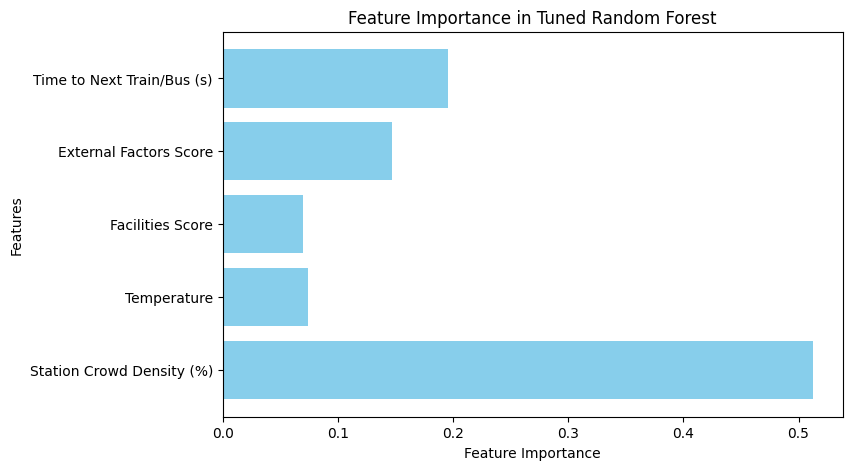

In [ ]:
# Plot feature importance
import matplotlib.pyplot as plt
importances = best_rf_model.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(X.columns, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Tuned Random Forest")
plt.show()

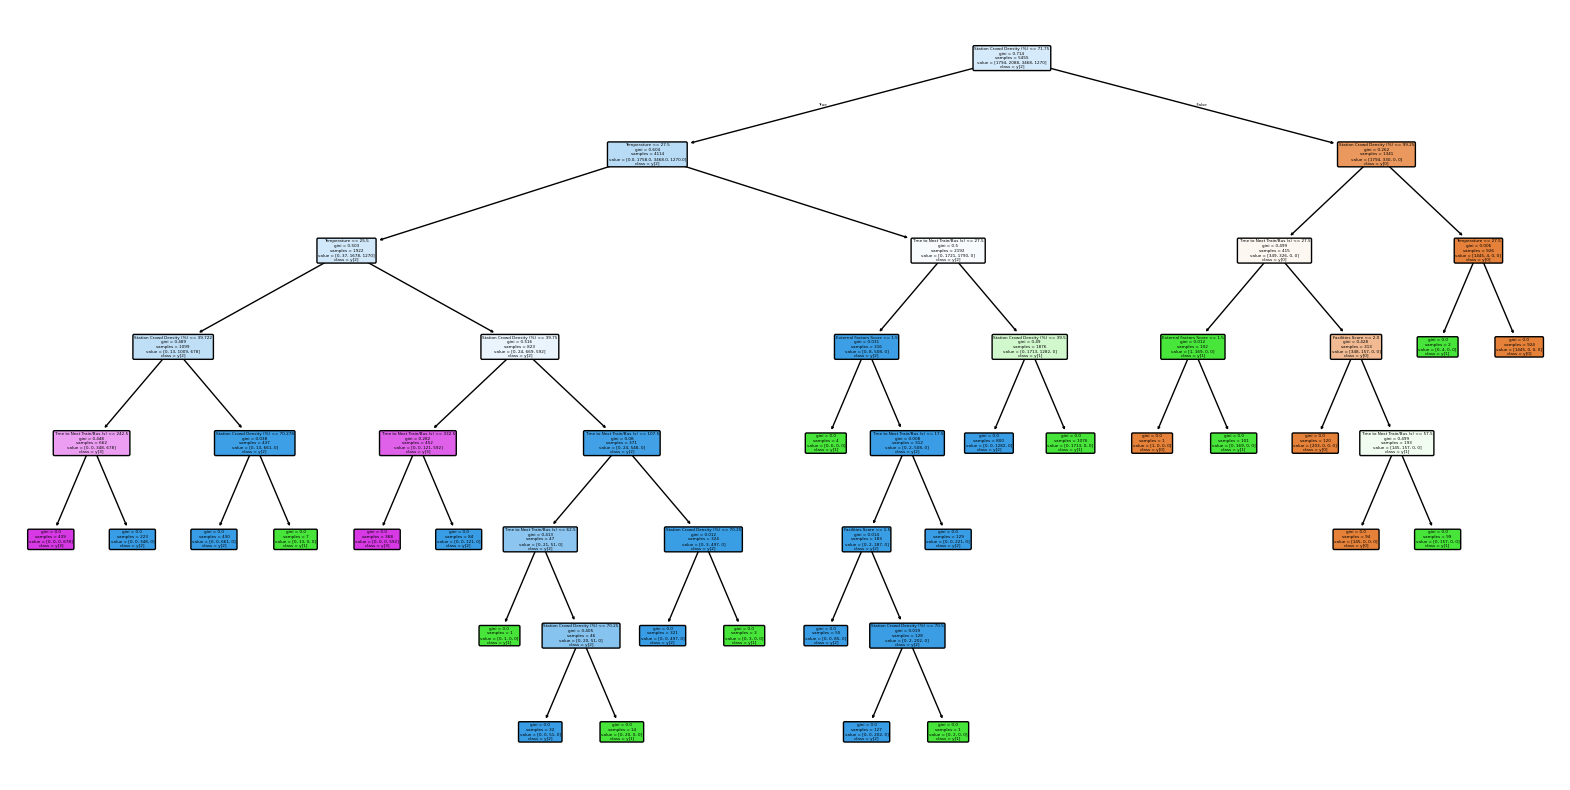

In [ ]:
# Showing decision tree
from sklearn.tree import plot_tree
estimator = best_rf_model.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(estimator, feature_names=X.columns, class_names=True, filled=True, rounded=True)
plt.show()

### Using model on case

In [ ]:
Case_df = pd.read_csv('/content/RM_finalcase.csv', delimiter = ';')

In [ ]:
Case_df

,Station,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Train/Bus (s),Facilities Score,External Factors Score
0,Setiabudi Astra MRT Station,17:31:00,24,13.333333,24,240,3,3
1,Dukuh Atas 1 Bus Station,17:31:00,43,43.000000,28,60,2,2
2,Bumiputera Bus Stop,17:31:00,20,100.000000,28,240,1,1
3,Dukuh Atas LRT Station,17:31:00,39,19.500000,27,300,3,3
4,Pancoran Bus Station,17:31:00,23,46.000000,28,140,1,2
5,Setiabudi Astra MRT Station,17:32:00,55,30.555556,24,180,3,3
6,Dukuh Atas 1 Bus Station,17:32:00,25,25.000000,28,120,2,2
7,Bumiputera Bus Stop,17:32:00,20,100.000000,28,180,1,1
8,Dukuh Atas LRT Station,17:32:00,62,31.000000,27,240,3,3
9,Pancoran Bus Station,17:32:00,13,26.000000,28,80,1,2


In [ ]:
Station_variables = Case_df[['Station Crowd Density (%)', 'Temperature', 'Facilities Score', 'External Factors Score', 'Time to Next Train/Bus (s)']]

In [ ]:
Station_score = best_rf_model.predict(Station_variables)

In [ ]:
Case_df['Station Score'] = Station_score

In [ ]:
Case_df

,Station,Timestamp,Passengers,Station Crowd Density (%),Temperature,Time to Next Train/Bus (s),Facilities Score,External Factors Score,Station Score
0,Setiabudi Astra MRT Station,17:31:00,24,13.333333,24,240,3,3,5.0
1,Dukuh Atas 1 Bus Station,17:31:00,43,43.000000,28,60,2,2,3.0
2,Bumiputera Bus Stop,17:31:00,20,100.000000,28,240,1,1,2.0
3,Dukuh Atas LRT Station,17:31:00,39,19.500000,27,300,3,3,5.0
4,Pancoran Bus Station,17:31:00,23,46.000000,28,140,1,2,3.0
5,Setiabudi Astra MRT Station,17:32:00,55,30.555556,24,180,3,3,5.0
6,Dukuh Atas 1 Bus Station,17:32:00,25,25.000000,28,120,2,2,4.0
7,Bumiputera Bus Stop,17:32:00,20,100.000000,28,180,1,1,2.0
8,Dukuh Atas LRT Station,17:32:00,62,31.000000,27,240,3,3,5.0
9,Pancoran Bus Station,17:32:00,13,26.000000,28,80,1,2,4.0


## A Star Route Optimization

In [ ]:
import heapq
import math

# Define the graph
graph = {
    "Dukuh Atas Area (Start)": {"Dukuh Atas 1 Bus Station": 2, "Setiabudi Astra MRT Station": 4, "Dukuh Atas LRT Station": 2, "Bumiputera Bus Stop": 6},
    "Dukuh Atas 1 Bus Station": {"Blok M Area (Destination)": 20},
    "Setiabudi Astra MRT Station": {"Blok M Area (Destination)": 15},
    "Dukuh Atas LRT Station": {"Pancoran Bus Station": 14},
    "Bumiputera Bus Stop": {"Blok M Area (Destination)": 24},
    "Pancoran Bus Station": {"Blok M Area (Destination)": 14},
    "Blok M Area (Destination)": {}
}

# Comfort scores for each station
comfort_scores = {
    "Dukuh Atas Area (Start)": 0,
    "Dukuh Atas 1 Bus Station": 3,
    "Setiabudi Astra MRT Station": 5,
    "Dukuh Atas LRT Station": 5,
    "Bumiputera Bus Stop": 2,
    "Pancoran Bus Station": 3,
    "Blok M Area (Destination)": 0
}

# Heuristic weight for comfort consideration
COMFORT_WEIGHT = 10.0  # Increased for higher impact

# Define the heuristic function
def heuristic(node, destination):
    """
    Heuristic function considering both travel time and comfort scores.
    """
    if node == destination:
        return 0

    # Approximate travel time
    travel_time = graph[node].get(destination, float('inf'))
    if travel_time == float('inf'):
        travel_time = sum(graph[node].values()) / max(len(graph[node]), 1)

    # Adjust comfort penalty with quadratic scaling
    comfort_score = comfort_scores[node]
    comfort_penalty = ((5 - comfort_score) / 5) ** 2

    h_value = math.sqrt(travel_time) * (1 + COMFORT_WEIGHT * comfort_penalty)
    #print(f"Heuristic for {node}: travel_time={travel_time}, comfort_penalty={comfort_penalty}, h_value={h_value}")
    return h_value

# A* algorithm implementation
def a_star_search(graph, start, destination):
    """
    Perform A* search to find the best route from start to destination.
    """
    priority_queue = [(0, start, [start])]
    g_costs = {start: 0}

    while priority_queue:
        current_f_cost, current_node, path = heapq.heappop(priority_queue)

        if current_node == destination:
            return path, g_costs[current_node]

        for neighbor, travel_time in graph[current_node].items():
            # Adjust travel time with comfort penalty
            comfort_score = comfort_scores[neighbor]
            comfort_penalty = ((5 - comfort_score) / 5) ** 2
            adjusted_cost = math.sqrt(travel_time) * (1 + COMFORT_WEIGHT * comfort_penalty)

            # Calculate g(n)
            new_g_cost = g_costs[current_node] + adjusted_cost

            if neighbor not in g_costs or new_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = new_g_cost

                # Calculate f(n)
                f_cost = new_g_cost + heuristic(neighbor, destination)
                heapq.heappush(priority_queue, (f_cost, neighbor, path + [neighbor]))
                #print(f"Node: {neighbor}, g_cost: {new_g_cost}, f_cost: {f_cost}")

    return None, float('inf')

# Testing the A* search
COMFORT_WEIGHT = 10.0  # Adjust for higher comfort impact
best_path, total_cost = a_star_search(graph, "Dukuh Atas Area (Start)", "Blok M Area (Destination)")

#print("Best Path:", best_path)
#print("Total Cost:", total_cost)
print("You are recommended to take the following route:")
for station in best_path:
    print(station)

You are recommended to take the following route:
Dukuh Atas Area (Start)
Setiabudi Astra MRT Station
Blok M Area (Destination)


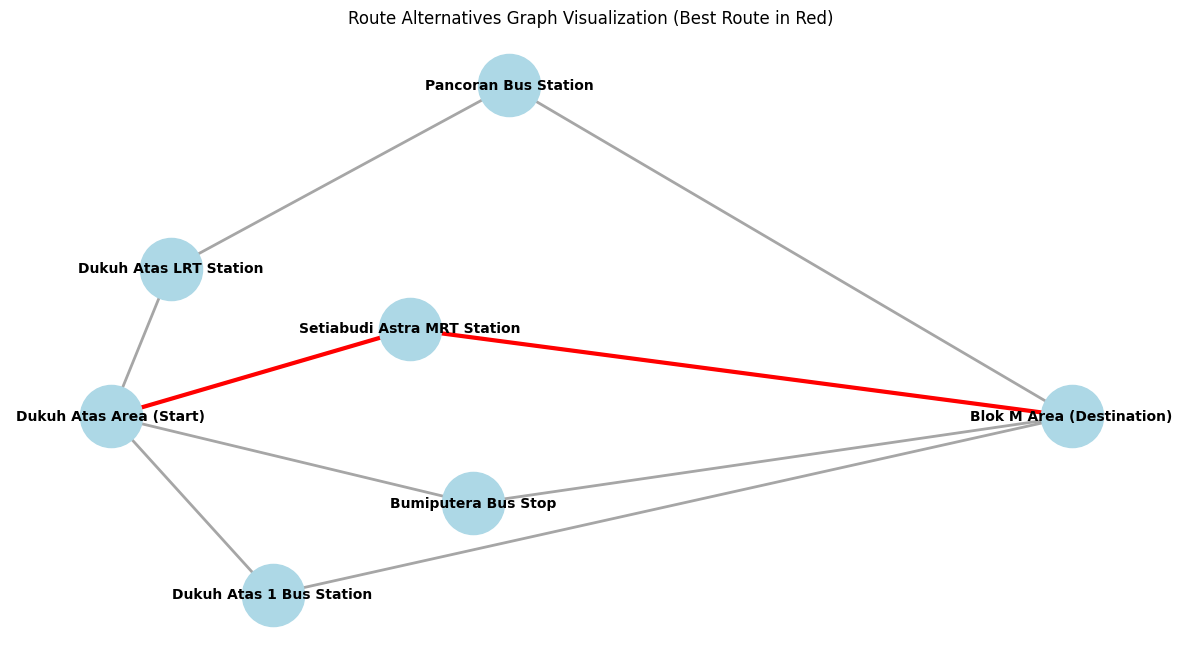

Best Path: ['Dukuh Atas Area (Start)', 'Setiabudi Astra MRT Station', 'Blok M Area (Destination)']


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define the graph with travel times as weights
edges = [
    ("Dukuh Atas Area (Start)", "Dukuh Atas 1 Bus Station", 2),
    ("Dukuh Atas Area (Start)", "Setiabudi Astra MRT Station", 4),
    ("Dukuh Atas Area (Start)", "Dukuh Atas LRT Station", 2),
    ("Dukuh Atas Area (Start)", "Bumiputera Bus Stop", 6),
    ("Dukuh Atas 1 Bus Station", "Blok M Area (Destination)", 20),
    ("Setiabudi Astra MRT Station", "Blok M Area (Destination)", 15),
    ("Bumiputera Bus Stop", "Blok M Area (Destination)", 24),
    ("Pancoran Bus Station", "Blok M Area (Destination)", 14),
    ("Dukuh Atas LRT Station", "Pancoran Bus Station", 14)
]

# Create a graph for visualization
G = nx.Graph()
G.add_nodes_from(["Dukuh Atas Area (Start)", "Dukuh Atas 1 Bus Station", "Setiabudi Astra MRT Station",
                 "Dukuh Atas LRT Station", "Bumiputera Bus Stop", "Pancoran Bus Station", "Blok M Area (Destination)"])
G.add_weighted_edges_from(edges)

# Initialize positions of nodes manually for left and right placement
pos = {
    "Dukuh Atas Area (Start)": [-2, 0],  # Start node on the left
    "Blok M Area (Destination)": [2, 0],  # Destination node on the right
}

# Use spring layout to place other nodes, then adjust manually
spring_pos = nx.spring_layout(G, seed=42, k=0.5)

# Adjust the positions of the other nodes to prevent overlap and maintain relative positions
pos["Dukuh Atas 1 Bus Station"] = spring_pos["Dukuh Atas 1 Bus Station"] + np.array([-2, 0.3])
pos["Setiabudi Astra MRT Station"] = spring_pos["Setiabudi Astra MRT Station"] + np.array([-0.5, 0.85])
pos["Dukuh Atas LRT Station"] = spring_pos["Dukuh Atas LRT Station"] + np.array([-0.75, -0.5])
pos["Bumiputera Bus Stop"] = spring_pos["Bumiputera Bus Stop"] + np.array([-1.25, -0.25])
pos["Pancoran Bus Station"] = spring_pos["Pancoran Bus Station"] + np.array([0.25, 0.5])

# Draw the graph
plt.figure(figsize=(15, 8))

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color="gray")

# Highlight the best route with a different color (dynamically based on best_path)
edges_best_route = [(best_path[i], best_path[i+1]) for i in range(len(best_path)-1)]
nx.draw_networkx_edges(G, pos, edgelist=edges_best_route, width=3, edge_color="red")

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", font_color="black")

# Show the plot
plt.title("Route Alternatives Graph Visualization (Best Route in Red)")
plt.axis("off")
plt.show()

# Output the best path
print("Best Path:", best_path)
